In [1]:
# general imports usually needed
import numpy as np
import matplotlib as mpl
import matplotlib.animation
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd

In [2]:
# libraries more specific to this lecture notebook
import os.path
import sys
sys.path.append('../../src')
from ml_python_class.config import DATA_DIR

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [3]:
# notebook wide settings to make plots more readable and visually better to understand
np.set_printoptions(suppress=True)

#%matplotlib widget
#%matplotlib inline

plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('figure', titlesize=18)
plt.rc('legend', fontsize=14)
plt.rcParams['figure.figsize'] = (12.0, 8.0) # default figure size if not specified in plot
plt.style.use('seaborn-darkgrid')


# 4. (Chapter 4) Training Models

In this chapter we will begin our study of Machine Learning algorithms in earnest.  Up
to this point you have gotten a taste of using some ML models as black boxes.
You don't really know internally what they are doing or how they work.  But still, learning
the API of how to create data sets and set up models for training, and knowning in
general what supervisied learning is and how you train a model to fit a dataset is
sufficient to start working with ML.

However, at some point you will be working with a dataset and you will get some
weird or unexpected results.  Also there are myriads of parameters and hyper-parameters,
not to mention issues with formatting and cleaning your data, and tweaking
training procedures, etc. that will all always be a bit mysterious and/or you will only
learn by wrote checklists, if you don't understand some of the fundamentals of the
internal implemenations of the various ML algorithms you use.

Understanding whats under the hood will help you quickly understand what types of ML
models will be promising or not for the data you have.  It will give you an understanding
of the hyper-parameters the model uses, and what you might want to try for these parameters
to get good results.  Understanding whats under the hood will also allow you to debug
and spot issues you have with training and debugging your models.  It will allow you
to perform error analysis, and better understand why your models may be working, and why
they may be failing, so that you can tweak things to improve their performance.

In short, while you can be a push-button/check-list using data analyst, if you eventually
want to improve your skills and become a better data scientist, you need to start
learning the internal working of ML algorithms.  Our goal in this class is to begin
your journey along this path.  We won't become experts on any of the ML methods we 
will look at, but we hope to introduce you to the fundamental concepts and inner
workings, so that you can beging to understand more deeply how the techniques work.

In this chapter, and units of our course, we will begin by looking at **linear regression**
(which we have used already), followed by **logistic regression**.  These units are very
important, as these models have basic concepts that are often similar across many types
of ML algorithms.  We will look at the idea of the **cost function** (or **fitness function**),
and how this can be used with techniques like **gradient descent** to fit the parameters
of a model in general to make predictions about a set of data.  Linear regression
is a technique for performing regression modeling (predict real valued outputs), while
logistic regression is useful for classification (despite its name, which is a bit
misleading at best).  By comparing similarities and differences of cost functions and
fitting models between regression and classification tasks, we will illustrate some general
principles of ML that apply to many types of supervisied learning models, whether
regression or classification tasks.

## 4.6 Logistic Regression

The linear regression examples we have used up to this point have all been applied to regression problems.  Recall
that by regression we mean we are fitting a model or forming a hypothesis where the output can be a real valued number
with in theory an infinite amount of precision.

But besides regression problems, another common type of supervisied learning problem we normally need to work with are
classification problems, where the ouput is a set of discrete categories.  In the simplest case, the labeled outputs
are binary, like yes/no, true/false or spam/ham classifications.

We need to use a slightly modified approch to solve a classification problem.  Some regression algorithms cna be used for
classification as well (and vice versa).  Logistic regression (despite its arguably slightly misnaming) is commonly
used to estimate the probability an instance belongs to a particular class.



### Estimating Probabilities

We will start by considering a binary classification first, and we will use labels of 0 and 1 to represent the false/true
classes respectively.  A logistic regression starts initially in the same way as a linear regression, by computing the weighted
sum of the input features (blus a bias term).  But instead of outputting this result directly like for linear regression, 
it outpus the **logistic** (also called **logit**, also called the **sigmoid** function) of this result.

\begin{equation}
\hat{p} = h_{\theta}(x) = \sigma \big( x^T \theta \big)
\end{equation}

This equation has the same weighted sum calculation as for linear regression ( $x^T \theta$ ).  But the
function $\sigma(\cdot)$ here denotes the logistic function.  The standard form of the Logistic/Sigmoid function is:

\begin{equation}
\sigma(z) = \frac{1}{1 + \exp(-t)}
\end{equation}

In [4]:
def sigmoid(z):
    """The basic sigmoid or logistic function.  Called sigmoid because of its S-shaped
    output.
    """
    return 1.0 / (1.0 + np.exp(-z))

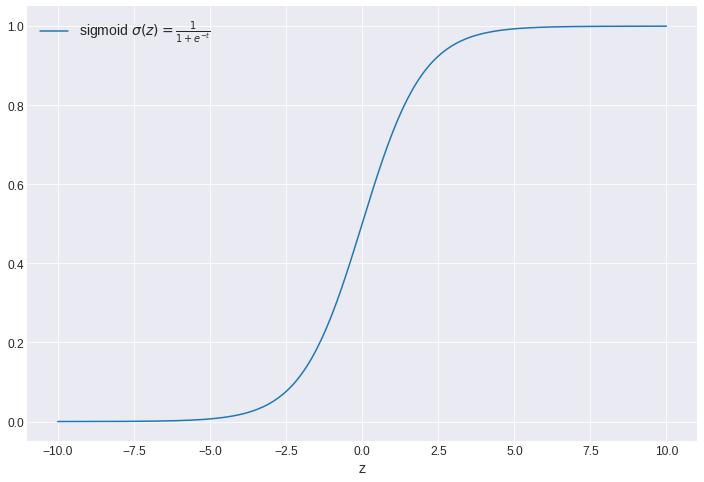

In [5]:
z = np.linspace(-10.0, 10.0, 250)
plt.plot(z, sigmoid(z), label=r'sigmoid $\sigma(z) = \frac{1}{1 + e^{-t}}$')
plt.xlabel('z')
plt.legend();

Notice that the result from the weighted sum ($z = x^T \theta$), no matter if it ends up as a very large negative
result or a very large positive result, it will always be squashed to some value between 0 and 1.  And result below
-5 or above 5 get effectively logited to 0 and 1 respectively, and values between will vary somewhere in between.

If we think of the output of the sigmoid function as a probability estimate, then we can interpret this output
as the probability $\hat{p}$ that the result is the positive (1) outcome for a binary classification.  Once the logistic
regression model has estimated the probability $\hat{p} = h_{\theta}(x)$ that an instance $x$ belongs to the
positive class, we can use a threshold to make our final prediction:

\begin{equation}
\hat{y} =
\begin{cases}
0 & \text{if} \;\; \hat{p} < 0.5 \\
1 & \text{if} \;\; \hat{p} \ge 0.5
\end{cases}
\end{equation}

Notice that, using this threshold, when $z < 0$ then we will predict the negative case or 0, and when $z \ge 0$ we
predict the positive case 1.

### Training and Cost Function

Given this modification of the weighted sum, we need to also modify the way we train our models.
The objective of training for a binary classifier is to set the paramter vector $\theta$ so that the
model estimates high propapilities for positive instances ($y = 1$) and low probabilities for 
negative instances ($y = 0$).  This idea is captured by a cost function like the following

\begin{equation}
c(\theta) =
\begin{cases}
-\log(\hat{p}) & \text{if} \;\; y = 1 \\
-\log(1 - \hat{p}) & \text{if} \;\; y = 0
\end{cases}
\end{equation}

To understnd this cost function, think of the two cases of $y = 1$ and $y = 0$ separately.  For the positive case
when we want the model to predict $y = 1$ the cost looks like the following (remember that $\hat{p}$ is
the output from the sigmod, so it will always be a value between 0 and 1):

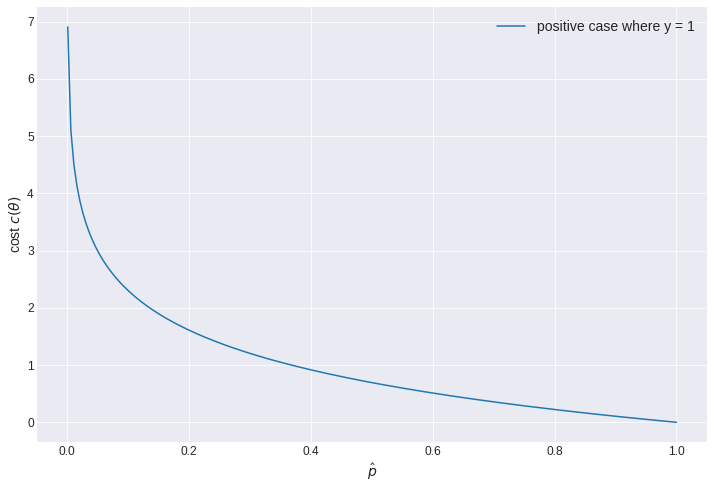

In [6]:
p = np.linspace(0.001, 1, 200) # log not defined at 0, so start at very small value
plt.plot(p, -np.log(p), label=r'positive case where y = 1')
plt.xlabel(r'$\hat{p}$')
plt.ylabel(r'cost $c(\theta)$')
plt.legend();

Again remember this is the cost function for all training instances where the correct answer is $y = 1$.
When the prediction probability $\hat{p}$ is 1.0, the cost of our cost function approaches 0.
This is what we want, the model is predicting well when it says there is a high probability it
is the $y = 1$ case when that is true.  But when $y = 1$ and the model is predicting a small
probability it is the positive case, we want the cost penality to be high for that prediction.

Likewise you will get a similar though mirrored cost function for the $y = 0$ training cases:

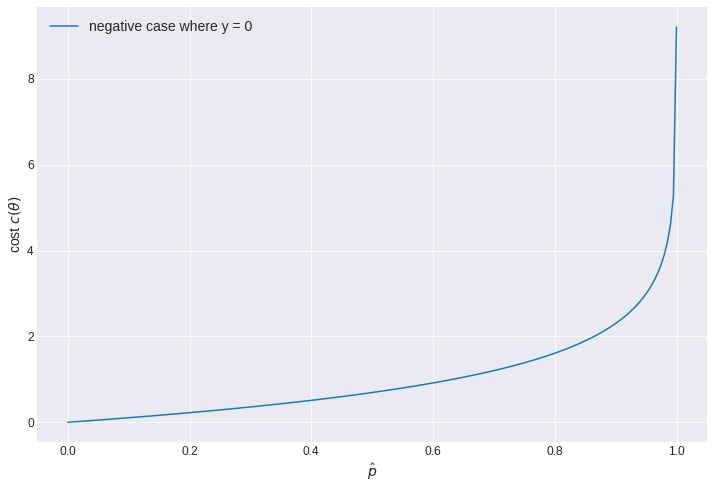

In [7]:
p = np.linspace(0, 0.9999, 200) # log not defined at 0, so start at very small value
plt.plot(p, -np.log(1.0 - p), label=r'negative case where y = 0')
plt.xlabel(r'$\hat{p}$')
plt.ylabel(r'cost $c(\theta)$')
plt.legend();

Make sure you see that the cost functions make sense.  For the 2 cases, they give low costs when the model is
making a good prediction, and the cost rapidly increases when the model is making a bad prediction.

Finally, to use this cost function, as we did before for the MSE, we have to average this cost function over the
whole training set of training inputs.  We can use a little bit of mathematical trickery to write this as a
single expression, even though our cost function has been expressed as a piecewise function so far.

\begin{equation}
J(\theta) = -\frac{1}{m} \sum_{i=0}^{m-1} \Big[ y^{(i)} \log \big( \hat{p}^{(i)} \big) + \big( 1 - y^{(i)} \big) \log \big( 1 - \hat{p}^{(i)} \big)   \Big]
\end{equation}

As before we have changed to 0 based indexing here, which is different from the text, to reflect our Python implementation.
Notice that inside of the summation, when $y = 1$ the left hand term will remain, but the right hand term will get 
zeroed out.  And likewise when $y = 0$ the left part gets zeroed out.

There is no known closed form solution to compute the value of $\theta$ that minimizes this cost function
(no equivalent of the normal equation).  So we cannot "solve" this analytically like for linear regression.

But this cost function is convex, like the linear regression MSE cost function.  So gradient descent (or any
optimization method) is guaranteed to find the global minimum (if the learning rate is not too large and you
wait long enough). 

The partial derivatives of the cost function with regards to the $j^{th}$ model parameter $\theta_j$ is given by:

\begin{equation}
\frac{\partial}{\partial \theta_j}  J(\theta) = \frac{1}{m} \sum_{i=0}^{m-1} \Big( \sigma \big( \theta^T x^{(i)} \big) - y^{(i)}  \Big) x_j^{(i)}
\end{equation}

It is beyond the scope of this course of how the partial derivative of the
cost funciton is derived here.  But you should go back and compare this equation
to the derivative of the MSE cost function that was derived.  They are
very similar (on purpose, this is one of the reason for picking the logit
here).  In fact the only difference is that we have to transform the
weighted sum term here using the sigmoid function, which we do not do for
the MSE derivative.  This means that we can use basically the same implementation
of gradient descent, with only a very small modification for both
linear and logistic regression.

Once you can calculate the gradients, we can use gradient descent in exactly the
same ways as discussed above.  We can use batch gradient descent, stochastic or
mini-batches.

### Decision Boundaries

The best way to visualize a logistic regression model is to determine and
plot the decision boundary that the model produces.  We will illustrate
the concept of a decision boundary for classification problems using the 
well known iris dataset.  This dataset has only 150 instances, with 4
separate features (sepal length, sepal width, petal length, petal width).  This
is a classification problem, there are 3 classes of irises in the
dataset, Setosa, Versicolor and Virginica.  We will later talk about how to
generalize logistic regression to problems with more than 2 classes.  But here, 
we will collapse the Setosa and Versicolor cases into one, and simply
classify either Virginica or not Virginica.

Start by getting the iris dataset from `sklearn`.

In [8]:
from sklearn import datasets
iris = datasets.load_iris()

# this is a dictionary, here are the items of the dataset we can use
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [9]:
# extract the input features, we are only using 1 feture to begin with, petal width
X = iris["data"][:, 3:]

# make the labels, 1 if virginica and 0 if not-virginica
y = (iris["target"] == 2).astype(np.int)

Use `sklearn` to train a `LogisticRegression` model.

In [10]:
# create and train a linear model using Logistic Regression
from sklearn.linear_model import LogisticRegression

In [11]:
log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

Here since we only use a single feature, the decision boundary will basically occur
at some specific petal width.  This will be the point where the
estimated probability of the learned hypothesis is at 0.5 (our threshold
value).

Lets visualize this boundary, and plot some of the instances in our
training set as well.

Decision boundary value [1.66066066]


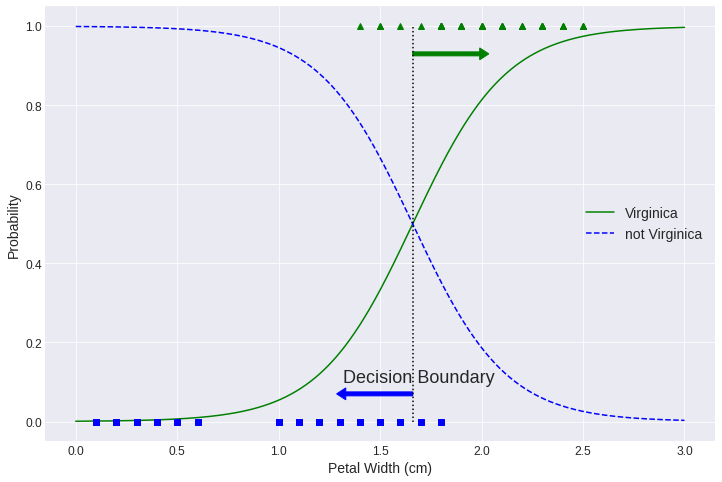

In [12]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:,1], 'g-', label="Virginica");

# rest of figure shown in textbook
plt.plot(X_new, 1.0 - y_proba[:,1], 'b--', label='not Virginica')

# determine the decision boundary value and visualize it
decision_index = min(np.where(y_proba[:,1] > 0.5)[0])
decision_value = X_new[decision_index]
print("Decision boundary value", decision_value)
plt.plot([decision_value, decision_value], [0, 1], 'k:')

# plot Virginica and not Virginica points to visualize how well the decision boundary works
not_virginica_width = X[y == 0]
not_virginica_y = np.zeros(not_virginica_width.shape)
plt.plot(not_virginica_width, not_virginica_y, 'bs')

virginica_width = X[y == 1]
virginica_y = np.ones(virginica_width.shape)
plt.plot(virginica_width, virginica_y, 'g^')

# add labels and such
plt.annotate(r'Decision Boundary',
             xy=(decision_value, 0.1), xycoords='data',
             xytext=(-70, 0), textcoords='offset points', fontsize=18)
plt.arrow(decision_value, 0.07, -0.33, 0, color='blue', linewidth=1.0, width=0.01)
plt.arrow(decision_value, 0.93, 0.33, 0, color='green', linewidth=1.0, width=0.01)

plt.xlabel('Petal Width (cm)')
plt.ylabel('Probability')
plt.legend();

The petal widths of Virginica range from 1.4 cm to 2.5 cm, while the other iris flowers have
smaller petal lengths, ranging from 0.1 cm to 1.8 cm.  Notice that there is a bit of overlap,
we cant get a perfect prediction with this attribute alone (petal width) of the iris
instances.  

There is a decision boundary at around 1.66 cm that the classifier learns here.  This will 
be the location of the learned parameter models where the probability for an input of the
petal width features results in a probability value of 0.5.  The black dotted line represents
the decision boundary, the location where the model predicted probability is 0.5.  A little smaller
than this decision boundary, and the model will predict the iris is not a Virginica.  A little 
bigger and it predicts it is Virginica.

The 0.5 threshold is used as the decision boundary.  Thus if we ask the logistic regressor to 
give us its best prediction, we will get a definitivie answer. For example:

In [13]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

The logistic regressor we used previously with a single feature can be used with 2 or many
more features.  But the logistic regressor we are currently using creates a linear model
for the data.  This means that the decision boundary will always be a straight line (or hyperplane
in 3 or more dimensions).  For example, if we train the Virginica/Not Virginica classifier on 
two features, petal width and petal length, we can see that the decision boundary that results
is a line in the 2 dimensions.

In [14]:
# extract the input features, use 2 features, petal length and petal width this time
X = iris["data"][:, 2:]

# make the labels, 1 if virginica and 0 if not-virginica
y = (iris["target"] == 2).astype(np.int)

In [15]:
log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

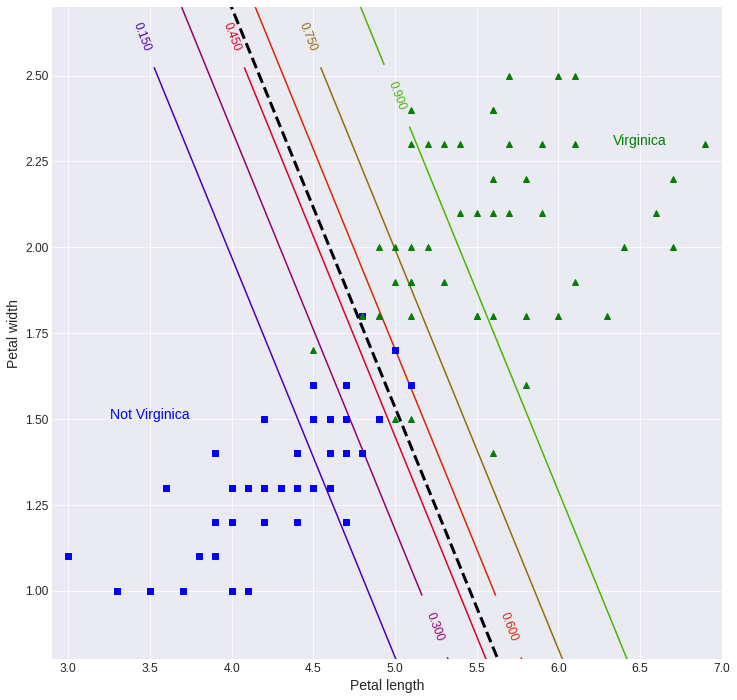

In [16]:
# create a mesh so we can use a contour plot to visualize the decision boundary
x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

# calculate probability on the mesh for the contour plot
y_proba = log_reg.predict_proba(X_new)

# plot the actual points, green triangles for Virginica, blue squares are not Virginica
plt.figure(figsize=(12, 12))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

# create contour plot
zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)



# plot the decision boundary as a dashed thick black line
left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]
plt.plot(left_right, boundary, "k--", linewidth=3)

# add in some labels and what not
plt.text(3.5, 1.5, "Not Virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7]);


Just like the linear regression models we discussed above, Logistic Regression models can be regularized using 
$\ell_1$ or $\ell_2$ penalities.  Scikit-learn adds an $\ell_2$ penality by default.

### Softmax Regression

The logistic regression model can be generalized to model multiple classes directly.  One approach is to train multiple
logistic classifiers on all of the combinations of class/not class and choose the one that gives the highest probability when 
we want to make predictions (discussed previously).

Another approach support multi-classes directly, called the **softmax regression** or **multinomial logistic regression**.  The idea
is similar.  The softmax regression first computes a score $s_k(x)$ for each class $k$, then it estimates the probability of each
class by applying the **softmax function** (also called the **normalized exponential**).  The equation to compute the initial score for
each class should look familia, as it is just like the equation for linear regress prediciton.

\begin{equation}
s_k(x) = x^T \theta^{(k)}
\end{equation}

This means that each class has its own dedicated parameter vector $\theta^{(k)}$.  So we are essentially again proposing separate classifiers
for each class.  All tese vectors are typically stored as rows in a **parameter matrix** $\Theta$.

Once you have computed the score of every class for the instance $x$, you can estimate the probability $\hat{p}_k$ that the instance belongs to class
$k$ by running the scores through the softmax function.  It computes the exponential of every score, then normalizes them (dividing by the 
sum of all the exponentials).  The scores are generally called logits or log-odds.

\begin{equation}
\hat{p}_k = \sigma(s(x))_k = \frac{\exp \big(s_k(x) \big)}{\sum_{j=1}^{K} \exp \big( s_j(x) \big)}
\end{equation}

Where 

- $K$ is the number of classes, if we have to we can renumber using 0 based indexing for implementation in Python
- $s(x)$ is a vector containing the scores of each class for the instance $x$.
- $\sigma \big( s(x) \big)_k $ is the estimated probability that the instance $x$ belongs to class $k$ given the scores of each class for that instance.

Just like the logistic regression classifier, the softmax regression classifier predicts the class with the highest estimated probability:

\begin{equation}
\hat{y} = \underset{k}{\text{argmax}} \; \sigma(s(x))_k = \underset{k}{\text{argmax}} \; s_k(x) = \underset{k}{\text{argmax}} \; \Big( \big(\theta^{(k)} \big)^T x \Big) 
\end{equation}

An example of training using the softmax regression classifier should make this more clear.  For training, we will minimize the
defined probability function $\hat{p}_k$ as our objective function.  The following equation is known as the **cross entropy**
cost function.

\begin{equation}
J(\Theta) = -\frac{1}{m} \sum_{i=0}^{m-1} \sum_{k=0}^{K-1} y_k^{(i)} \log \big( \hat{p}_k^{(i)} \big)
\end{equation}

Here $y_k^{(i)}$ is the target probability that the $i^{th}$ instance belongs to class $k$.  In will be either equal to 1 or 0 depending
on whether the instance $i$ belongs to the class or not.

Notice that where there are just two classes ($K=2$) this cost function is equivalent to the logistic regression's cost function.

Given this cost function, we need the gradient vector of the cost function with regards to $\theta^{(k)}$.  The derivation is the same
as for the logistic regression.  We end up with the following formalization for calculating the gradients

\begin{equation}
\bigtriangledown_{\theta^{(k)}} J(\Theta) = \frac{1}{m} \sum_{i=0}^{m-1} \big( \hat{p}_k^{(i)} - y_k^{(i)}  \big) x^{(i)}
\end{equation}

Given this expression for the gradient, we can use gradient descent to perform the softmax regression.  Of course, this will all be
done for us using scikit-learn.  Lets use scikit-learn's `LogisticRegression` class to classify all 3 iris flower classes.
Scikit-learn `LogisticRegression` uses one-versus-all by default when you train it on more than two classes, but you can set the
`multi_class` hyperparameter to `"multinomial"` to switch it to softmax regression instead.  You must also specify a solver
(gradient descent algorith) that supports softmax regression, such as the `"lbgs"` solver.  It also applies $\ell_2$ regularization
by default, which you can control using the hyperparameter $C$.

In [17]:
X = iris["data"][:, (2,3)] # still only using petal length and petal width
y = iris["target"] # but use all of the targets

In [18]:
softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial')

So once the mode is trained, we can ask it to predict.  Like with one-versus-all, asking to `predict` will give the predicted class label.
And we can use the `predict_proba` function to see the individual softmax probability estimates for each class the model is trained with.

In [19]:
# prediction for an iris with 5cm petal length and 2cm petal width
softmax_reg.predict([[5,2]])

array([2])

In [20]:
# probabilities, these are in the order defined by y=0,1,2
# which is Setosa, Versicolor and Virginica respecitvely
softmax_reg.predict_proba([[5,2]])

array([[0.00000064, 0.057493  , 0.94250636]])

Softmax gives an almost 94.3% probability prediction that this iris should be in the Virginica class, with a 5.7% probability that it is 
the versicolor.

We can also plot the resulting decision boundary reached by this softmax regressor.  Notice that the decision boundaries between any 2
classes are still linear.

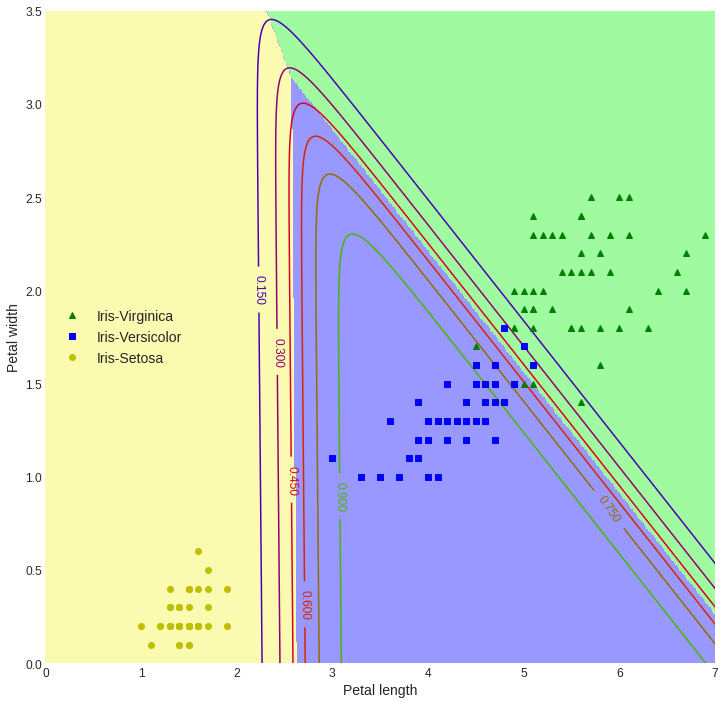

In [21]:
# create a meshgrid so we can make a contour plot of the decision boundaries
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


# make predictions over the grid for the contour plot
y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

# plot the contour map
plt.figure(figsize=(12, 12))
zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)

# Plot the actual data points, color and shape coded
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

# add labels and plot information
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5]);
